In [1]:
import sys
import os
from pathlib import Path

# Retrocedemos un nivel desde 'notebooks' para llegar a la raíz del proyecto
root_path = Path(os.getcwd()).parent
sys.path.append(str(root_path / "src"))

# Ahora puedes importar tu config normalmente
from goes_processor import config_satpy

# Verificación de carga de archivos (basado en tu archivo config_satpy.py)
print(f"Ruta de búsqueda Satpy: {config_satpy.satpy.config.get('config_path')}")

--- Configuración SatPy (v.0.0.1) ---
✅ Carpeta de configuración detectada: /home/legion/bulk/MAIE_tesis2026/f01_code/MAIE_tesis_github/src/goes_processor/satpy_configs
  - abi.yaml: Encontrado
  - abi.yaml: Encontrado
  - Cache: resample_cache
  - Log: WARNING
---------------------------------------
Ruta de búsqueda Satpy: ['/home/legion/bulk/MAIE_tesis2026/f01_code/MAIE_tesis_github/src/goes_processor/satpy_configs']


In [5]:
# 1. Importar configuraciones globales y Satpy
#import config_satpy  # Esto registra la carpeta satpy_configs
from satpy import Scene
import matplotlib.pyplot as plt
%matplotlib inline
import glob


In [6]:
# 2. Buscar un archivo .nc de LST dinámicamente
# Ajustamos la búsqueda a la carpeta de datos crudos (raw)
data_raw_path = root_path / "data" / "raw" / "noaa-goes19"

# Buscamos archivos que contengan 'LST' y terminen en '.nc'
# El patrón recursivo '**/*.nc' ayuda si están en subcarpetas por fecha
files = glob.glob(str(data_raw_path / "**/*LST*.nc"), recursive=True)

if not files:
    raise FileNotFoundError(f"No se encontraron archivos LST en: {data_raw_path}")

# Tomamos el primero de la lista para la prueba
input_file = files[0]
print(f"Archivo encontrado: {input_file}")



Archivo encontrado: /home/legion/bulk/MAIE_tesis2026/f01_code/MAIE_tesis_github/data/raw/noaa-goes19/ABI-L2-LSTF/2026/003/05/OR_ABI-L2-LSTF-M6_G19_s20260030500230_e20260030509538_c20260030515145.nc


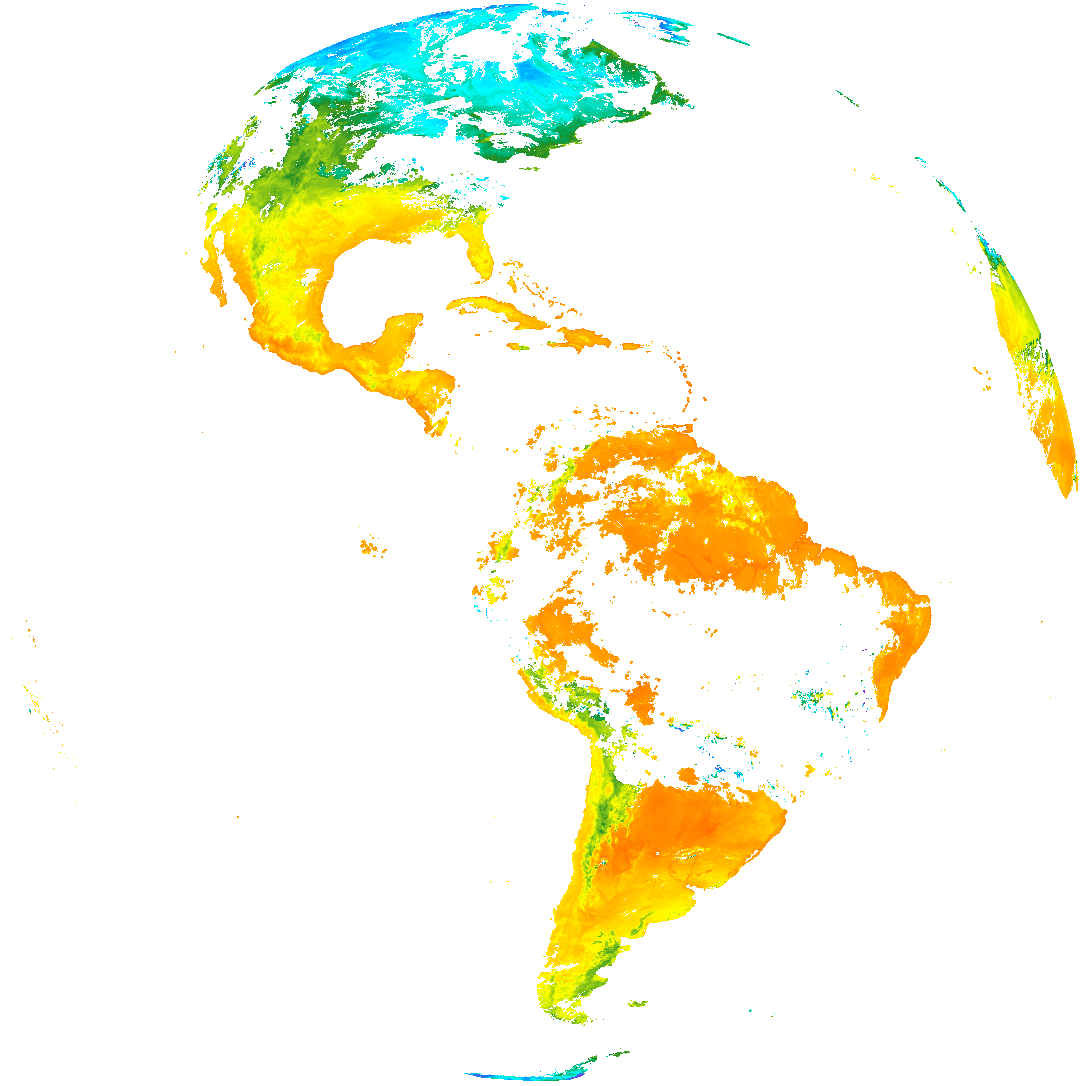

In [10]:
# 3. Cargar la escena
scn = Scene(reader="abi_l2_nc", filenames=[input_file])

# 4. Cargar tu producto personalizado (definido en abi.yaml)
product = "lstf_kelvin_color01"
scn.load([product])

# 5. Remuestrear
# Usamos el área de Full Disk 10km que mencionaste en tus scripts previos
#resampled_scn = scn.resample("goes_west_abi_f_10km") 

# 6. Visualizar
scn.show(product)

# 7. Verificar metadatos
#print(scn[product].attrs)

In [16]:
from pyresample import AreaDefinition

# Definición para 3600x1800 (Resolución 0.1°)
area_id = 'global_wgs84_3600x1800'
description = 'Mapa Global WGS84'
proj_id = 'epsg4326'
projection = 'EPSG:4326'
width = 3600
height = 1800
# Extensión: [lon_min, lat_min, lon_max, lat_max]
area_extent = [-180.0, -90.0, 180.0, 90.0]

target_area = AreaDefinition(area_id, description, proj_id, projection, 
                             width, height, area_extent)

/home/legion/bulk/MAIE_tesis2026/f01_code/MAIE_tesis_github/venv/lib/python3.12/site-packages/dask/_task_spec.py:768: RuntimeWarning: invalid value encountered in sin
  return self.func(*new_argspec)
/home/legion/bulk/MAIE_tesis2026/f01_code/MAIE_tesis_github/venv/lib/python3.12/site-packages/dask/_task_spec.py:768: RuntimeWarning: invalid value encountered in cos
  return self.func(*new_argspec)
/home/legion/bulk/MAIE_tesis2026/f01_code/MAIE_tesis_github/venv/lib/python3.12/site-packages/dask/_task_spec.py:768: RuntimeWarning: invalid value encountered in sin
  return self.func(*new_argspec)
/home/legion/bulk/MAIE_tesis2026/f01_code/MAIE_tesis_github/venv/lib/python3.12/site-packages/dask/_task_spec.py:768: RuntimeWarning: invalid value encountered in cos
  return self.func(*new_argspec)


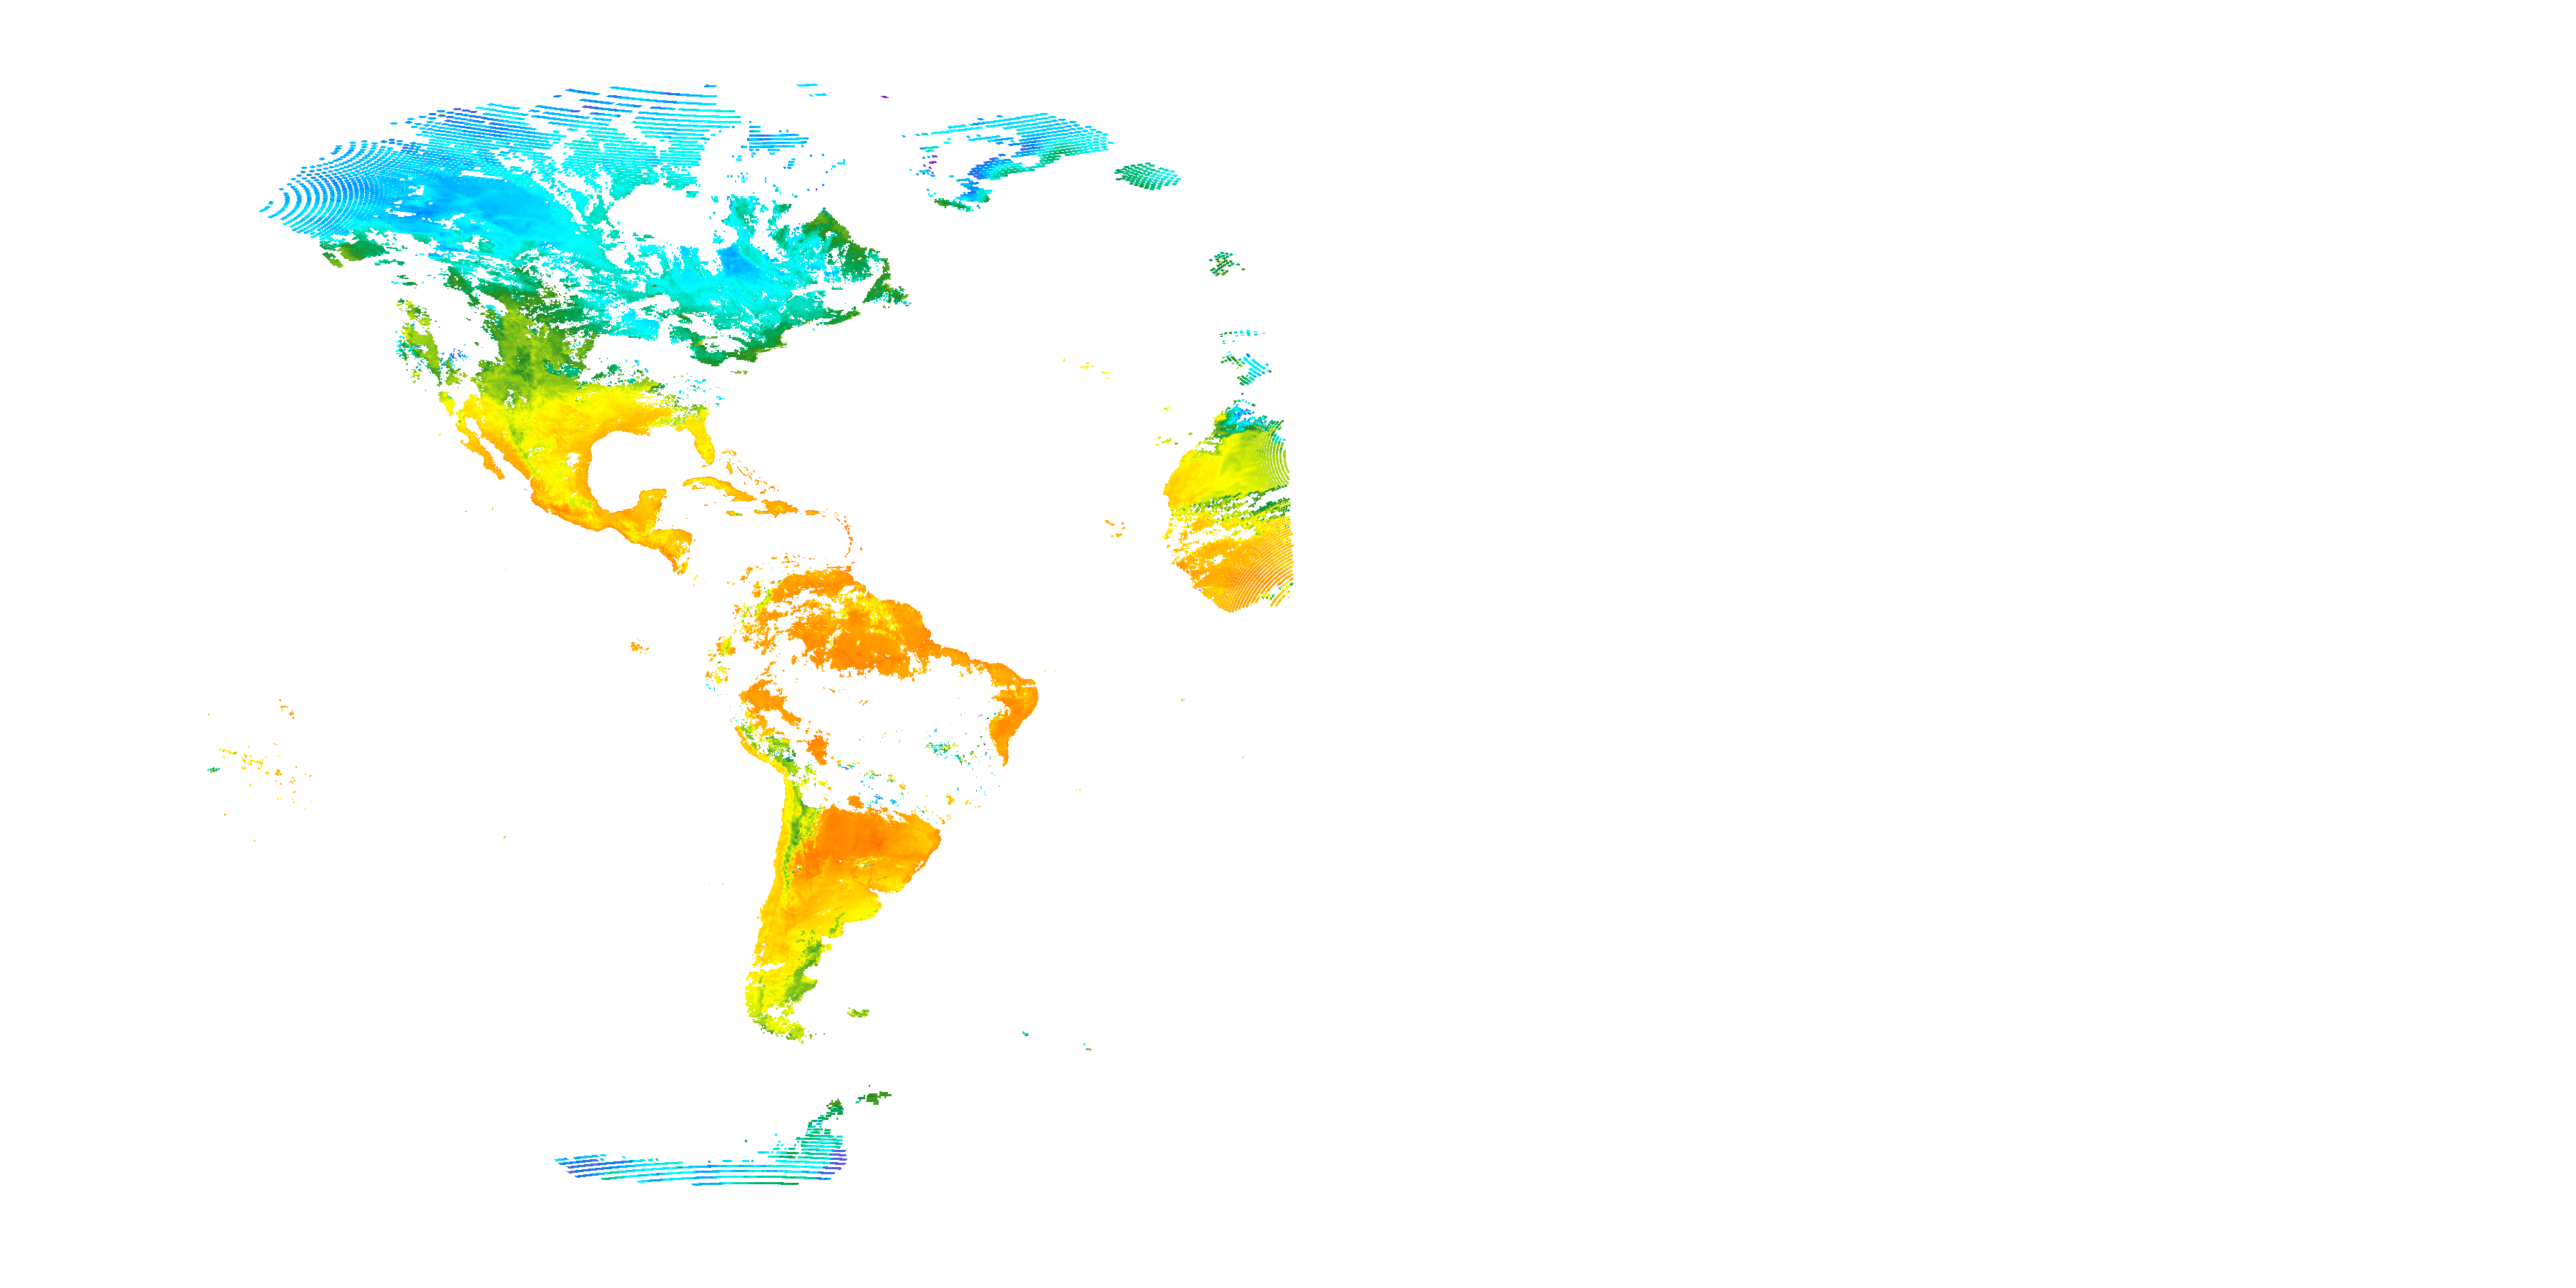

In [17]:
# 1. Remuestrear la escena al área global de 3600x1800
resampled_scn = scn.resample(target_area)

# 2. Cargar el producto con tus colores personalizados (lstf_kelvin_color01)
# Satpy aplicará el realce de abi_enhancements.yaml automáticamente
product = "lstf_kelvin_color01"

# 3. Guardar como GeoTIFF (Ideal para ver la extensión total)
resampled_scn.save_dataset(
    product, 
    filename='LST_Global_3600x1800.tif',
    writer='geotiff'
)

# 4. Mostrar en la notebook
resampled_scn.show(product)

In [18]:
from pyresample import AreaDefinition

# 1. Definir el área WGS84 (3600x1800 para resolución de 0.1 grados)
area_id = 'global_wgs84'
target_area = AreaDefinition(
    area_id, 
    'Global WGS84 0.1deg', 
    'epsg4326', 
    'EPSG:4326', 
    3600, 1800, 
    [-180, -90, 180, 90]
)

# 2. Remuestrear la escena
resampled_scn = scn.resample(target_area)

# 3. Guardar el GeoTIFF con colores aplicados
# El producto 'lstf_kelvin_color01' ya tiene la operación 'colorize' vinculada
product = "lstf_kelvin_color01"

resampled_scn.save_dataset(
    product, 
    filename='LST_WGS84_Coloreado.tif', 
    writer='geotiff'
)

print("¡Archivo guardado con éxito!")

/home/legion/bulk/MAIE_tesis2026/f01_code/MAIE_tesis_github/venv/lib/python3.12/site-packages/dask/_task_spec.py:768: RuntimeWarning: invalid value encountered in sin
  return self.func(*new_argspec)
/home/legion/bulk/MAIE_tesis2026/f01_code/MAIE_tesis_github/venv/lib/python3.12/site-packages/dask/_task_spec.py:768: RuntimeWarning: invalid value encountered in cos
  return self.func(*new_argspec)


¡Archivo guardado con éxito!


In [15]:
from pyresample import load_area
import os
import satpy

# Cargar el archivo como una lista
areas_list = load_area(os.path.join(os.path.dirname(satpy.__file__), 'etc', 'areas.yaml'))

# Extraer los nombres (nemos) de los objetos en la lista
nombres_areas = [area.area_id for area in areas_list]
print([name for name in nombres_areas if 'goes' in name.lower()])

['goes_east_abi_f_500m', 'goes_east_abi_f_1km', 'goes_east_abi_f_2km', 'goes_west_abi_f_500m', 'goes_west_abi_f_1km', 'goes_west_abi_f_2km', 'goes_east_abi_c_500m', 'goes_east_abi_c_1km', 'goes_east_abi_c_2km', 'goes_west_abi_p_500m', 'goes_west_abi_p_1km', 'goes_west_abi_p_2km']
